## Test a gradient boosting model on full dataset

In [1]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.

import pandas as pd
# Make the graphs a bit prettier, and bigger
pd.set_option('display.mpl_style', 'default')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 20)

import numpy as np
import math
# The usual preamble
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
plt.rcParams['axes.color_cycle'] = ['r', 'g', 'b', 'c']
plt.rcParams['lines.color'] = 'r'
plt.rcParams['figure.figsize'] = (15, 5)

import process
from modeling import categorize

Populating the interactive namespace from numpy and matplotlib


/Users/along528/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Load in dataset

In [2]:
test_data,val_data = process.get_split_add_data()
val_data

,urban,rural,institutionalized_all,institutionalized_adult_all,institutionalized_adult_federal_detention_all,institutionalized_adult_federal_prison_all,institutionalized_adult_state_prison_all,institutionalized_adult_local_jail_all,institutionalized_juvenile_all,institutionalized_white,institutionalized_adult_white,institutionalized_adult_federal_detention_white,institutionalized_adult_federal_prison_white,institutionalized_adult_state_prison_white,institutionalized_adult_local_jail_white,institutionalized_juvenile_white,institutionalized_black,institutionalized_adult_black,institutionalized_adult_federal_detention_black,institutionalized_adult_federal_prison_black,institutionalized_adult_state_prison_black,institutionalized_adult_local_jail_black,institutionalized_juvenile_black,population_white,population_black,total_income_estimate_all,total_income_estimate_white,total_income_estimate_black,swnauthemp,swnftemp,...,chiefmin_per_capita,chiefmax_per_capita,sgtmin_per_capita,sgtmax_per_capita,entrymin_per_capita,entrymax_per_capita,nummrkcars_per_capita,numothmrk_per_capita,numumkcars_per_capita,numothunm_per_capita,numplanes_per_capita,numcopters_per_capita,numboats_per_capita,nummotor_per_capita,numcarcam_per_capita,numfixcam_per_capita,nummobcam_per_capita,rpsi,black_over_white_population_disparity,black_over_white_income_disparity,black_over_white_institutionalized_disparity,black_over_white_institutionalized_adult_disparity,black_over_white_institutionalized_adult_federal_detention_disparity,black_over_white_institutionalized_adult_federal_prison_disparity,black_over_white_institutionalized_adult_state_prison_disparity,black_over_white_institutionalized_adult_local_jail_disparity,black_over_white_institutionalized_juvenile_disparity,black_officer_disparity,white_officer_disparity,black_over_white_officer_disparity
surveyid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1222,26616,31,186,0,0,0,0,0,13,144,0,0,0,0,0,5,37,0,0,0,0,0,6,24649,323,9712,9063,35,65,65,...,4.943333,4.943333,2.824183,2.965287,1.670695,2.456337,0.000675,0.000150,0.000450,0.000150,0,0.000000,0.000075,0.000038,0.000075,0.000525,0.000000,3.067020,0.013104,0.003862,0.256944,1.000000,1,1.000000,1.000000,1.000000,1.200000,0.000000,1.031163,0.000000
184,110372,0,1149,219,0,0,0,0,44,861,83,0,0,0,0,23,209,82,0,0,0,0,13,64836,22146,40950,26944,7822,300,300,...,0.987569,1.032871,0.576197,0.587504,0.406117,0.414127,0.001196,0.000190,0.000734,0.000136,0,0.000000,0.000000,0.000082,0.000000,0.000027,0.000027,1.356672,0.341569,0.290306,0.242741,0.987952,1,1.000000,1.000000,1.000000,0.565217,0.348868,1.361861,0.256170
175,123919,0,2194,1277,0,0,0,1095,119,1027,378,0,0,0,309,46,683,512,0,0,0,436,46,36606,48114,46061,17050,17580,592,417,...,0.960305,1.129770,0.541951,0.579822,0.331822,0.499568,0.001477,0.000234,0.000912,0.000169,0,0.000000,0.000024,0.000105,0.000347,0.000016,0.000000,1.708121,1.314375,1.031085,0.665044,1.354497,1,1.000000,1.000000,1.411003,1.000000,0.389109,2.118801,0.183646
170,78229,2653,1904,1341,0,1339,0,0,25,1162,637,0,637,0,0,17,434,406,0,406,0,0,7,55191,5803,29034,21017,1763,152,148,...,1.319354,1.344082,0.831322,0.856433,0.596734,0.765881,0.000519,0.000111,0.000334,0.000074,0,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,1.210668,0.105144,0.083884,0.373494,0.637363,1,0.637363,1.000000,1.000000,0.411765,0.376702,1.307061,0.288205
174,59531,1435,427,0,0,0,0,0,82,363,0,0,0,0,0,43,53,0,0,0,0,0,28,41750,12292,23342,16691,4492,107,101,...,1.512157,1.512157,1.170128,1.170128,0.796690,1.060739,0.000377,0.000098,0.000328,0.000066,0,0.000000,0.000000,0.000066,0.000197,0.000000,0.000016,2.385800,0.294419,0.269127,0.146006,1.000000,1,1.000000,1.000000,1.000000,0.651163,0.147321,1.359057,0.108400
179,73240,0,790,0,0,0,0,0,59,673,0,0,0,0,0,34,59,0,0,0,0,0,14,46607,9530,27832,19961,2811,160,172,...,1.256144,1.392682,0.881649,1.089364,0.666562,0.887862,0.000410,0.000137,0.000164,0.000096,0,0.000000,0.000000,0.000055,0.000000,0.000000,0.0000

In [ ]:
val_data.to_sql('val_data',process.engine,if_exists='replace')



In [ ]:
val_data

# Build Model

In [3]:
processor = process.Processor(val_data,categorize=False)
X_val,y_val = processor.get_scaled_Xy(val_data)
X_test,y_test = processor.get_scaled_Xy(test_data)

In [4]:
len(val_data)

147

In [5]:
val_data_scaled = pd.DataFrame(np.c_[X_val,y_val],index=val_data.index,columns=val_data.drop('rpsi',1).columns.tolist()+['rpsi'])
val_data_scaled.to_sql('val_data_scaled',process.engine,if_exists='replace')#print X_val+y_val

In [ ]:
plt.hist(val_data['rpsi'].tolist(),bins=40)

In [ ]:
val_data_scaled['rpsi']

In [6]:
for cat in sort(val_data_scaled['rpsi'].map(categorize).unique().tolist()):
    
    print cat, shape(val_data_scaled[val_data_scaled['rpsi'].map(categorize)==cat])[0]

0 51
1 44
2 52


In [ ]:
np.shape(X_val)[1]

In [54]:
from sklearn import linear_model,cross_validation,metrics,grid_search
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
n_features = np.shape(X_val)[1]

params = {'n_estimators':5000, 
          'max_depth': 2, 
          'min_samples_split': 1,
          'learning_rate': 0.001, 
          'loss': 'ls'}

clf = GradientBoostingRegressor(**params)

clf.fit(X_val,y_val)
est = clf
mse = mean_squared_error(y_val, clf.predict(X_val))
mse

0.16786503642682787

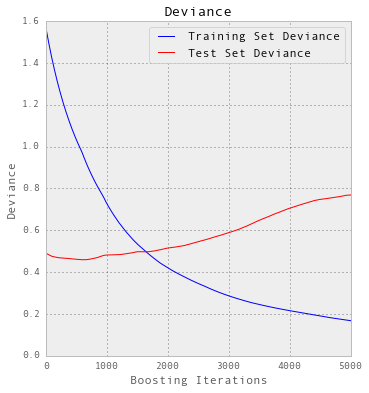

In [55]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [45]:
print clfmodel.best_params_
print clfmodel.best_score_
est = clf

features = []
importances = []
for feature,importance in zip(val_data.drop('rpsi',1).columns.tolist(),clfmodel.best_estimator_.feature_importances_):
    #print feature,importance
    features.append(feature)
    importances.append(importance)
indices = [i[0] for i in sorted(enumerate(importances), key=lambda x:x[1])]
best_feature_names = []
for index in reversed(indices):
    print features[index],importances[index]
    if importances[index] < 0.005:
        continue
    best_feature_names.append(features[index])
print len(best_feature_names)

{'n_estimators': 150, 'learning_rate': 0.5, 'max_depth': 15}
0.0
asian_per_capita 0.0357633706353
totacad 0.00968199488684
sgtmin 0.00446861636586
entrymax 0.0040201578446
black 0.0036117862354
opbudget_per_capita 0.0035322852866
total_income_estimate_white_per_capita 0.0023136890664
numfixcam_per_capita 0.00226923573661
institutionalized_juvenile_white 0.00222536205923
institutionalized_juvenile_white_per_capita 0.00198713837487
entrymin 0.00163029926027
numinvst_per_capita 0.00159102516285
black_over_white_institutionalized_adult_local_jail_disparity 0.00145980099535
amerind_per_capita 0.00139924533523
totgender_per_capita 0.00111137237102
nummotor_per_capita 0.00103233000299
black_over_white_institutionalized_disparity 0.000934355183317
population_black 0.000667212466956
rural 0.00065330412552
swnftemp_per_capita 0.000625676192832
totftemp_per_capita 0.000598898864287
numpatr 0.000588217949959
institutionalized_juvenile_all 0.00055761632923
chiefmax 0.000549302840365
swnftemp 0.0005

In [ ]:
import pickle
pickle.dump(best_feature_names,open('best_features_names_reg.p','wb'))


In [ ]:
import pickle
best_feature_names = pickle.load(open('best_features_names_reg.p','rb'))
print best_feature_names

In [ ]:
import pickle
pickle.dump(est,open('randomforestclassifier_fixed_reg.p','wb'))

In [ ]:
est = pickle.load(open('randomforestclassifier_fixed_reg.p','rb'))
print est

In [46]:
est.score(X_val,y_val)

0.62692661313239673

In [47]:
est.score(X_test,y_test)

-0.097186238859239049

In [48]:
def categorize(rpsi):
    if rpsi >=0 and rpsi <=1.6:
        return 0
    elif rpsi < 2.2:
        return 1
    else: return 2


In [49]:
#classification
nmatch = 0
total = 0
y_predict=[]
for y in est.predict(X_test).tolist():
    y_predict.append(categorize(y))
y_actual=[]
for y in y_test.tolist():
    y_actual.append(categorize(y))

from collections import defaultdict
cattotal = defaultdict(int)
for prediction, actual in zip(y_predict,y_actual):
    ismatch = prediction==actual
    cattotal[actual]+=1
    if ismatch:
        nmatch+=1
    total+=1

print "test accuracy =",float(nmatch)/float(total)
print "total",total
for cat in cattotal:
    print cat,float(cattotal[cat])/float(total)

test accuracy = 0.361111111111
total 36
0 0.361111111111
1 0.333333333333
2 0.305555555556


In [23]:

x = est.predict(X_val)
y = y_val


(0, 12)

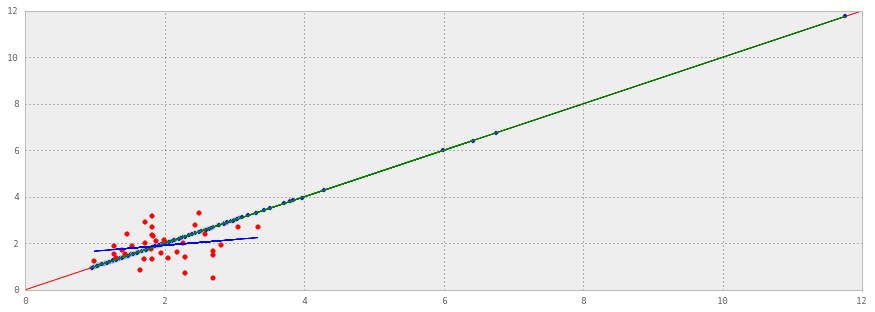

In [24]:
plt.scatter(est.predict(X_val),y_val)
plt.scatter(est.predict(X_test),y_test,color='r')



plt.plot(np.linspace(0, 12, 1000),np.linspace(0, 12, 1000))

x = est.predict(X_val)
y = y_val
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))

x = est.predict(X_test)
y = y_test
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))

plt.ylim([0,12])
plt.xlim([0,12])

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_actual,y_predict) #clfmodel2.predict(X_test))
plt.pcolor(matrix.T.T)
plt.colorbar()
matrix

In [ ]:
sql_query = """
    SELECT  * FROM traffic_joined_with_features;
    """
data = add_features(get_data())

descriptors = []
descriptors = ['agency','city','state','zipcode']
test = pd.read_sql_query(sql_query,con).drop('index',axis=1)
test = test[test['surveyid'].isin(data.index.tolist())]
#test = test.merge(data,how='right',right_on='surveyid')
#data = add_features(get_data())[best_feature_names+['agency']]
#test
test = test.sort(columns='surveyid').set_index('surveyid',drop=True)
test = test[descriptors]
test
sorted_data = data.sort_index()
sorted_data = sorted_data[best_feature_names]
output = pd.concat([test,sorted_data],axis=1)
output

In [ ]:
import pickle
#clf = pickle.load(open('randomforestclassifier.p','rb'))
best_feature_names = pickle.load(open('best_features_names.p','rb'))

In [ ]:
plt.pcolor(np.abs(np.corrcoef((X_val.T))))
plt.colorbar()

In [ ]:
plot_data

In [ ]:
plot_data = process.add_features(process.get_data())
processor = process.Processor(val_data,categorize=False)
X,y = processor.get_scaled_Xy(plot_data)
Xy = np.c_[y,X]

feature_names = ['rpsi']+plot_data.drop(['rpsi'],1).columns.tolist()
correlations = np.corrcoef(Xy)[0].tolist()
indices = np.argsort(correlations).tolist()
indices.reverse()
for index in indices:
    print feature_names[index],correlations[index]